# Aprendizado por reforço utilizando a biblioteca gymnasium

* O primeiro passo é instalar as bibliotecas:
  * gymnasium
  * swig
  * gymnasium[box2d]

In [ ]:
!pip install gymnasium

In [ ]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.7 MB/s eta 0:00:00


In [ ]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379416 sha256=481cf4eded453dac46a4104e269b155e2ac42983d272bf72c86dd69fb396d277
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


* Após a instalação da biblioteca é necessário definir um ambiente de simulação. No exemplo abaixo será utilizado o ambiente "Taxi-V3". No site oficial da biblioteca gymnasium (https://gymnasium.farama.org/) existem outros exemplos para testar algoritmos de aprendizado por reforço.

* O ambiente pode ser crido para os seguintes modelos de renderização (parâmetro "render_mode" do método "make"):
  * ansi
  * human
  * rgb_array

In [ ]:
import gymnasium as gym

# Initialise the environment
env = gym.make("Taxi-v3", render_mode="ansi")
#env = gym.make("Taxi-v3", render_mode="rgb_array")

## Tutorial

* Após criar um ambiente é necessário fazer o reset para que o agente seja colocado em um ponto do ambiente e em seguida fazer a renderização. A renderização irá depender do modo com que você criou o ambiente (parâmetro "render_mode" do método "make()".

In [ ]:
env.reset()

(6, {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)})

In [ ]:
env.render()

'+---------+\n|\x1bR\x1b: | : :\x1bG\x1b|\n| : | : : |\n| : : : : |\n| | : | : |\n|\x1bY\x1b| : |B: |\n+---------+\n\n'

* O exemplo a ser implementado é o do taxi. Neste exemplo o agente (taxista) precisa buscar um passageiro em um dos quatro pontos do ambiente (azul, verde, vermelho e amarelo). Após pegar o passageiro, o taxi precisa se deslocar até o destino (o hotel) para deixar o passageiro.

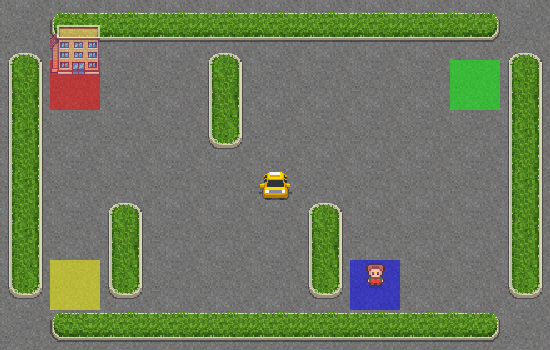

* Os movimentos permitidos para o agente taxista são os seguintes:
  * para cima (south) : 0
  * para baixo (north) : 1
  * para a direita (east) : 2
  * para a esquerda (west) : 3
  * pegar o passageiro : 4
  * deixar o passageiro : 5

* O espaço de observação é calculado da seguinte forma:
  * o ambiente é um grid de 5 X 5 posições (25 posições)
  * o passageiro pode estar em cinco localizações (ponto vermelho, amarelo, azul, verde ou dentro do taxi)
  * são quatro destinos para o passageiro

* logo, o espaço de observação é composto por 500 estados (5 x 5 x 5 x 4).  

* O aprendizado por reforço visa treinar um agente para executar uma tarefa em um determinado ambiente. Para que o agente receba feeedback sobre sua interação no ambiente existe um método de recompensa que pode ser negativa ou positiva.

* Particularmente no problema do taxi as recompensas são as seguintes:
  * -1 por andar no ambiente, ao menos que outra recompensa seja atribuída;
  * +20 por deixar o passageiro no local correto;
  * -10 excutar ações de pegar e deixar o passageiro de forma equivocada.

In [ ]:
env.reset()

(8, {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)})

In [ ]:
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [ ]:
print(env.step(0))
print(env.render())

(108, -1, False, False, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



* Implementando a tabela Q

In [ ]:
import numpy as np

* Declare uma tabela Q (quality) com formato np.array com n spaces linhas e n actions colunas.

In [ ]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [ ]:
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
import random
from IPython.display import clear_output
import numpy as np

* Após criar e inicializar a tabela Q com zeros é necessário implementar o algoritmo de aprendizado do agente.

* O agente irá interagir com o ambiente por n episódios. Cada episódio representa a ação completa de pegar o passageiro e levá-lo ao ponto de desembarque ou falhar, ou seja, deixar o passageiro no local errado.

* A atualização da tabela Q é feita com base na Equação de Bellman:

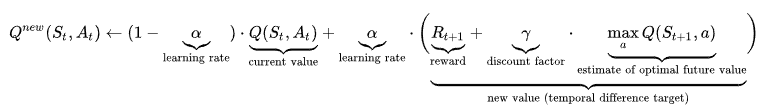

* A equação de Bellman especifica alguns fatores necessários para o aprendizado do agente, tais como:

  * Taxa de aprendizado (fator alfa)
  * Fator de desconto (gama)

* O valor Q é calculado com base no par ação-estado anteriores (atual, considerando cada passo de treinamento).

* O fator alfa (taxa de aprendizado) determina a velocidade de aprendizado. Valores próximos a zero tendem a fazer atualizações na tabela Q com base na recompensa atual e com valores próximos a um tendem a fazer atualizações com recompensas baseado no próximo par estado-ação.

* O fator gama aplica um desconto em relação a recompensa futura (par estado-ação). Se este valor for próximo a um será dado maior importância a recompensa futura. Se o valor for próximo a zero daremos mais importância a recompensa atual.

* A sequência de ações a serem executadas no processo de treinamento, ou seja, da construção da tabela Q é a seguinte:

  * Inicializar a tabela Q com valores zero;
  * Escolher uma ação (considerando o equilíbrio entre exploration e exploitation);
  * Executar uma ação;
  * Calcular a recompensa;
  * Atualizar a tabela Q.


In [ ]:
alfa = 0.1
gama = 0.6
epsilon = 0.1  # Estratégia conhecida na literatura da área como estratégia epsion-greedy. Serve para estabelecer uma probabilidade do agente fazer exploration ou exploitation.

In [ ]:
for i in range(1, 10000):
  estado, _ = env.reset()
  epocas, penalizacao, recompensa = 0, 0, 0
  concluido = False

  while not concluido:
    # Exploração -> ação aleatória
    if random.uniform(0 ,1) < epsilon:
      acao = env.action_space.sample()
    # Exploitation -> ação definida na tabela Q
    else:
      acao = np.argmax(q_table[estado])

    prox_estado, recompensa, concluido, _ , informacoes = env.step(acao)

    q_antigo = q_table[estado, acao]
    prox_valor_max = np.max(q_table[prox_estado])

    q_novo = (1 - alfa) * q_antigo + alfa * (recompensa + gama * prox_valor_max)
    q_table[estado, acao] = q_novo

    if recompensa == -10:
      penalizacao += 1

    estado = prox_estado
    epocas += 1

  if i % 100 == 0:
    clear_output(wait=True)
    print(f"Episodio: {i}")

print(f"Treinamento concluido... epocas: {epocas}")

Episodio: 9900
Treinamento concluido... epocas: 14


In [ ]:
q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.41059552,  -2.35880173,  -2.41296993,  -2.35672328,
         -2.27325184, -11.28434123],
       [ -1.8641755 ,  -1.45794881,  -1.86445822,  -1.45268867,
         -0.7504    , -10.1296352 ],
       ...,
       [ -1.11054828,   0.38576414,  -1.14125484,  -1.15385591,
         -2.80537738,  -3.57771032],
       [ -2.11556936,  -2.11215866,  -2.11612824,  -2.11215001,
         -4.42339339,  -3.60082679],
       [  0.38299946,   0.28482724,   0.80407998,  10.99920162,
         -2.40560753,  -1.        ]])

In [ ]:
env.reset()
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
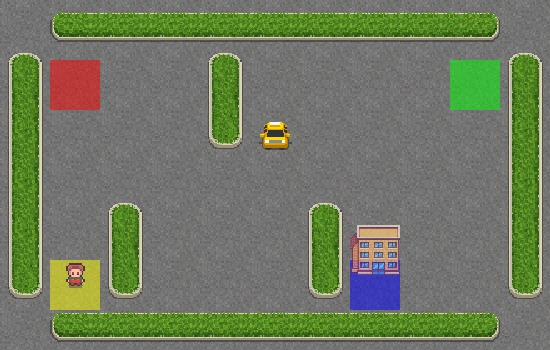

In [ ]:
env.render()

* Após treinar o agente e obter a tabela Q é possível testar o agente.

* Execute o algoritmo por n episódios e faça o computo das penalidades.

In [ ]:
total_penalidades = 0
episodios = 10
total_epocas = 0

In [ ]:
import time

In [ ]:
for _ in range(episodios):
  estado, _ = env.reset()
  penalidades, recompensa, epocas = 0, 0, 0
  concluido = False

  while not concluido:
    acao = np.argmax(q_table[estado])
    print(f"Acao: {acao}")


    estado, recompensa, concluido, _, informacoes = env.step(acao)

    if recompensa == -10:
      penalidades += 1

    epocas += 1

    clear_output(wait=True)
    print(env.render())
    time.sleep(.1)

  total_penalidades =+ penalidades
  total_epocas += epocas

print(f"Penalidade total {total_penalidades} em {total_epocas} epocas.")


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Penalidade total 0 em 398 epocas.


# Aula

In [ ]:
# politica -> PI
# estado -> mudar localizacao ou algo equivalente

In [ ]:
import gymnasium as gym

In [ ]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")

In [ ]:
env.reset()

(0, {'prob': 1})

In [ ]:
env.step(1)

(8, 0.0, False, False, {'prob': 0.3333333333333333})

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
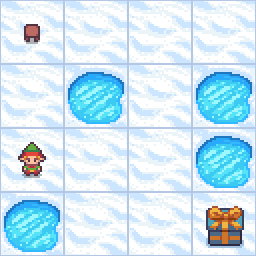

In [ ]:
env.render()

In [ ]:
import numpy as np
import random
from IPython.display import clear_output
import time


q_table = np.zeros([env.observation_space.n, env.action_space.n])


alfa = 0.1
gama = 0.6
epsilon = 0.1  # Estratégia conhecida na literatura da área como estratégia epsion-greedy. Serve para estabelecer uma probabilidade do agente fazer exploration ou exploitation.


q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
for i in range(1, 10000):
  estado, _ = env.reset()
  epocas, penalizacao, recompensa = 0, 0, 0
  concluido = False

  while not concluido:
    # Exploração -> ação aleatória
    if random.uniform(0 ,1) < epsilon:
      acao = env.action_space.sample()
    # Exploitation -> ação definida na tabela Q
    else:
      acao = np.argmax(q_table[estado])

    prox_estado, recompensa, concluido, _ , informacoes = env.step(acao)

    q_antigo = q_table[estado, acao]
    prox_valor_max = np.max(q_table[prox_estado])

    q_novo = (1 - alfa) * q_antigo + alfa * (recompensa + gama * prox_valor_max)
    q_table[estado, acao] = q_novo

    if recompensa == -10:
      penalizacao += 1

    estado = prox_estado
    epocas += 1

  if i % 100 == 0:
    clear_output(wait=True)
    print(f"Episodio: {i}")

print(f"Treinamento concluido... epocas: {epocas}")


Episodio: 9900
Treinamento concluido... epocas: 10


array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
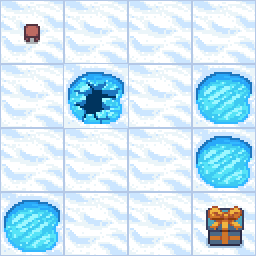

In [ ]:
env.render()

In [ ]:
total_penalidades = 0
episodios = 10
total_epocas = 0




for _ in range(episodios):
  estado, _ = env.reset()
  penalidades, recompensa, epocas = 0, 0, 0
  concluido = False

  while not concluido:
    acao = np.argmax(q_table[estado])
    print(f"Acao: {acao}")


    estado, recompensa, concluido, _, informacoes = env.step(acao)

    if recompensa == -10:
      penalidades += 1

    epocas += 1

    clear_output(wait=True)
    #print(env.render())
    time.sleep(.1)

  total_penalidades =+ penalidades
  total_epocas += epocas

print(f"Penalidade total {total_penalidades} em {total_epocas} epocas.")



Penalidade total 0 em 168 epocas.
